In [1]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [3]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 10)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

class VAE_NF_12feat(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div
    

#sigmodel = VAE_NF(N_FLOWS, Z_DIM).cuda()

sigmodel = VAE_NF_12feat(10, 4).cuda()
bkgmodel = VAE_NF_12feat(10, 4).cuda()
bkgmodel2 = VAE_NF_12feat(10, 8).cuda()

sigae_def = {
                        "type":"sig",
                        "trainon":"2prong",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta10p0",
                        "zdimnflow":f"z4f10",
                        "version":f"ver0"

                     }

bkgae_def = {
                        "type":"bkg",
                        "trainon":"rndbkg",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta10p0",
                        "zdimnflow":f"z4f10",
                        "version":f"ver0"

                     }

sigae3prong_def = {
                        "type":"sig",
                        "trainon":"3prong",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta10p0",
                        "zdimnflow":f"z4f10",
                        "version":f"ver0"

                     }


directory = '/data/t3home000/spark/QUASAR/weights'
bkgmodel.load_state_dict(torch.load(f"{directory}/{bkgae_def['type']}_{bkgae_def['trainon']}_{bkgae_def['features']}_{bkgae_def['architecture']}_{bkgae_def['selection']}_{bkgae_def['trainloss']}_{bkgae_def['beta']}_{bkgae_def['zdimnflow']}_{bkgae_def['version']}.h5"))
sigmodel.load_state_dict(torch.load(f"{directory}/{sigae_def['type']}_{sigae_def['trainon']}_{sigae_def['features']}_{sigae_def['architecture']}_{sigae_def['selection']}_{sigae_def['trainloss']}_{sigae_def['beta']}_{sigae_def['zdimnflow']}_{sigae_def['version']}.h5"))
bkgloss_rndbkg = np.load(f"../data_strings/{bkgae_def['type']}_{bkgae_def['trainon']}_{bkgae_def['features']}_{bkgae_def['architecture']}_{bkgae_def['selection']}_{bkgae_def['trainloss']}_{bkgae_def['beta']}_{bkgae_def['zdimnflow']}_{bkgae_def['version']}_bkgloss.npy")
sigloss_rndbkg = np.load(f"../data_strings/{sigae_def['type']}_{sigae_def['trainon']}_{sigae_def['features']}_{sigae_def['architecture']}_{sigae_def['selection']}_{sigae_def['trainloss']}_{sigae_def['beta']}_{sigae_def['zdimnflow']}_{sigae_def['version']}_bkgloss.npy")
bkgloss_prong2 = np.load(f"../data_strings/{bkgae_def['type']}_{bkgae_def['trainon']}_{bkgae_def['features']}_{bkgae_def['architecture']}_{bkgae_def['selection']}_{bkgae_def['trainloss']}_{bkgae_def['beta']}_{bkgae_def['zdimnflow']}_{bkgae_def['version']}_sigloss.npy")
sigloss_prong2 = np.load(f"../data_strings/{sigae_def['type']}_{sigae_def['trainon']}_{sigae_def['features']}_{sigae_def['architecture']}_{sigae_def['selection']}_{sigae_def['trainloss']}_{sigae_def['beta']}_{sigae_def['zdimnflow']}_{sigae_def['version']}_sigloss.npy")


sig2loss_rndbkg = np.load(f"../data_strings/{sigae3prong_def['type']}_{sigae3prong_def['trainon']}_{sigae3prong_def['features']}_{sigae3prong_def['architecture']}_{sigae3prong_def['selection']}_{sigae3prong_def['trainloss']}_{sigae3prong_def['beta']}_{sigae3prong_def['zdimnflow']}_{sigae3prong_def['version']}_bkgloss.npy")
sig2loss_prong2 = np.load(f"../data_strings/{sigae3prong_def['type']}_{sigae3prong_def['trainon']}_{sigae3prong_def['features']}_{sigae3prong_def['architecture']}_{sigae3prong_def['selection']}_{sigae3prong_def['trainloss']}_{sigae3prong_def['beta']}_{sigae3prong_def['zdimnflow']}_{sigae3prong_def['version']}_sigloss.npy")




In [8]:
def get_mass_and_loss(filename):
    
    bkg_mean = [229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]
    
    bkg_std = [131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]
    
    sig_mean = [489.6699791129437,
 0.22463354907052815,
 0.639679230886038,
 0.7742464847783065,
 1.4122267488712905,
 253.95296492556145,
 167.8782919951573,
 0.3429350853771621,
 0.6460772390759577,
 0.7653966882661628,
 1.4541020071952622,
 165.34100428967955]
    
    sig_std = [66.87936517220672,
 0.1361910116638729,
 0.15309413231859276,
 0.10054671892302457,
 0.3833027691949484,
 87.45977372109115,
 50.53622336909848,
 0.14930126292179366,
 0.15096516491915418,
 0.10415175051343364,
 0.44297590229588857,
 55.44436453890166]
    
    
    sig2_mean = [539.8230906175115,
 0.3093919504152834,
 0.5743852002513076,
 0.7250999951321894,
 1.3980643297136106,
 305.10717416378316,
 417.50598164552935,
 0.3423973996112709,
 0.5859205785605542,
 0.7492831266044925,
 1.6350968023267969,
 261.31617070357555]
    
    sig2_std = [104.54956422929888,
 0.12679648500311186,
 0.13543619747203547,
 0.11808533829680096,
 0.34103400809131684,
 100.12586819876644,
 88.97967256083908,
 0.1495063860755517,
 0.14289850921322486,
 0.11224475793826029,
 0.5509216479879365,
 82.84269505360622]
    
    #supervised_loss_list = []
    #sigae_loss_list = []
    #bkgae_loss_list = []

    
    f = pd.read_hdf(filename)
    dt = f.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])
        
    correct = (dt[:,0]>=2800)
    dt = dt[correct]

    correct = (dt[:,3]>100)
    dt = dt[correct]

    correct = (dt[:,19]>20)
    dt = dt[correct]
    
    X_no_jetmass = dt[:,[4,5,6,11,12,20,21,22,27,28]]
    X_with_jetmass = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    X_sig = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    X_bkg = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
        
    for i, (bkgmean,bkgstd,sigmean,sigstd) in enumerate(zip(bkg_mean,bkg_std,sig_mean, sig_std)):
        X_bkg[:,i] = (X_with_jetmass[:,i]-bkgmean)/bkgstd
        X_sig[:,i] = (X_with_jetmass[:,i]-sigmean)/sigstd
        #print(bkgmean,bkgstd)
        
    bkgae_test = torch.tensor(X_bkg)
    sigae_test = torch.tensor(X_sig)
    
    
    sigmodel.eval()
    bkgmodel.eval()
    sigae_loss = torch.mean((sigmodel(sigae_test.float().cuda())[0]- sigae_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bkgae_loss = torch.mean((bkgmodel(bkgae_test.float().cuda())[0]- bkgae_test.float().cuda())**2,dim=1).data.cpu().numpy()
    

    return dt[:,0], sigae_loss, bkgae_loss

        
    
    

In [9]:
mass, sigloss, bkgloss = get_mass_and_loss('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [208]:
bkg_mass, bkg_sigloss, bkg_bkgloss = get_mass_and_loss('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5')

In [220]:
bb_mass  = np.load('blackbox_mass.npy')
bb_sigloss = np.load('blackbox_sigloss.npy')
bb_bkgloss = np.load('blackbox_bkgloss.npy')
qcd_mass = np.load('QCDMC_mass.npy')
qcd_sigloss = np.load('QCDMC_sigloss.npy')
qcd_bkgloss = np.load('QCDMC_bkgloss.npy')

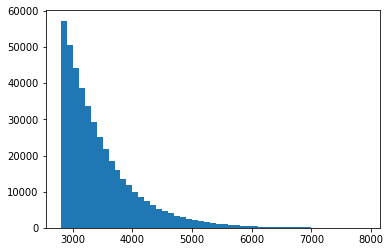

In [210]:
plt.hist(bkg_mass[], bins = np.arange(2800,8000,100));

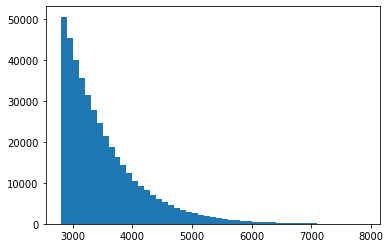

In [11]:
plt.hist(mass, bins = np.arange(2800,8000,100));

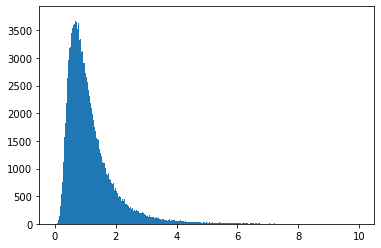

In [34]:
plt.hist(bkgloss,bins=np.arange(0,10,0.01));

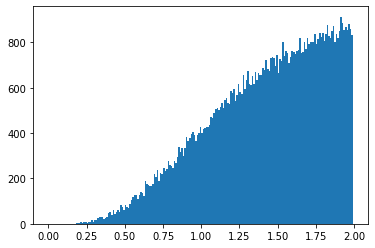

In [191]:
plt.hist(sigloss,bins=np.arange(0,2,0.01));

In [145]:
bbidx = np.where( (bkgloss > 5) & (sigloss<8))[0]

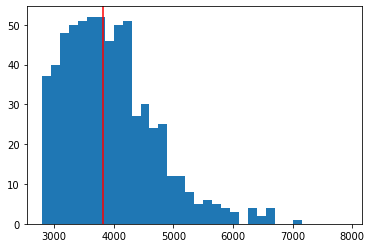

In [223]:
bbidx = np.where( (bkgloss > 5) & (sigloss<6))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,150));
plt.axvline(x=3823,color='r')

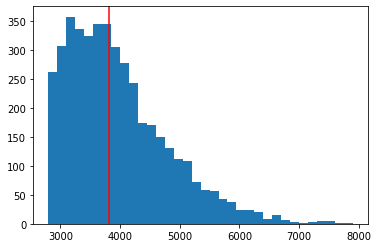

In [149]:
bbidx = np.where( (bkgloss > 4) & (sigloss<7.5))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,150));
plt.axvline(x=3823,color='r')

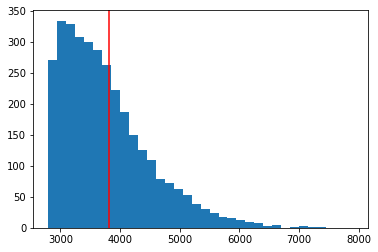

In [153]:
bbidx = np.where( (bkgloss > 3.7) & (sigloss<5))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,150));
plt.axvline(x=3823,color='r')

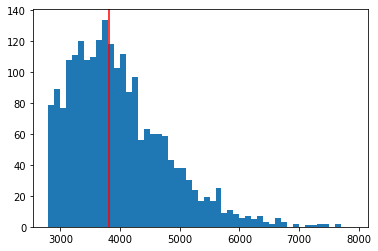

In [158]:
bbidx = np.where( (bkgloss > 4.5) & (sigloss<7))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,100));
plt.axvline(x=3823,color='r')

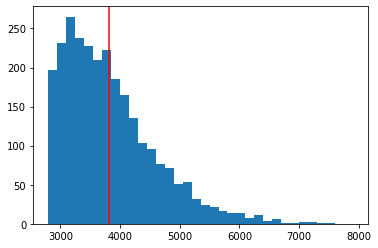

In [176]:
bbidx = np.where( (bkgloss > 4) & (sigloss<5.5))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,150));
plt.axvline(x=3823,color='r')

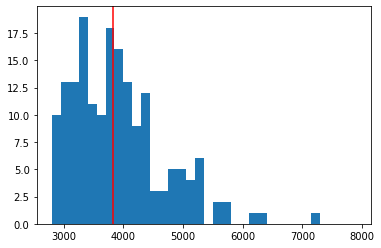

In [211]:
bkg_bbidx = np.where( (bkg_bkgloss > 5.8) & (bkg_sigloss<8))[0]
plt.hist(bkg_mass[bkg_bbidx], bins = np.arange(2800,8000,150));
plt.axvline(x=3823,color='r')

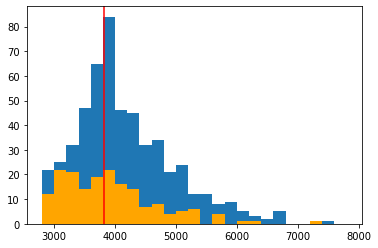

In [226]:
bbidx = np.where( (bkgloss > 5.8) & (sigloss<8))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,200));
plt.axvline(x=3823,color='r')

bkg_bbidx = np.where( (bkg_bkgloss > 5.8) & (bkg_sigloss<8))[0]
plt.hist(bkg_mass[bkg_bbidx], bins = np.arange(2800,8000,200),color='orange');


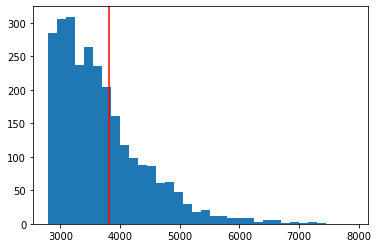

In [207]:
bbidx = np.where( (bkgloss > 3.3) & (sigloss<3.6))[0]
plt.hist(mass[bbidx], bins = np.arange(2800,8000,150));
plt.axvline(x=3823,color='r')